In [1]:
import scanpy as sc
import pandas as pd
from scipy.spatial.distance import mahalanobis
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import random
from collections import Counter

## Read datasets

In [29]:
st_path = '/home/vlada/ssi/data/4K/Mouse_brain_ST.h5ad'  # /goofys/projects/SSI/datasets
sc_path = '/home/vlada/ssi/data/4K/Mouse_brain_SC.h5ad'

adata_sc = sc.read_h5ad(sc_path)
adata_st = sc.read_h5ad(st_path)

sc_df_raw = pd.DataFrame(adata_sc.X, index=adata_sc.obs.index, columns=adata_sc.var.index).copy()
st_df_raw = pd.DataFrame(adata_st.X.toarray(), index=adata_st.obs.index, columns=adata_st.var.index).copy()

/home/vlada/miniconda3/envs/svc/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## Calculate Marker genes

In [31]:
sc.pp.normalize_total(adata_sc, target_sum=1e4)
sc.pp.log1p(adata_sc)
adata_sc.var_names_make_unique()
sc.pp.highly_variable_genes(adata_sc, inplace=True, n_top_genes=200)

sc.tl.rank_genes_groups(adata_sc, groupby="cell_subclass", use_raw=False)
markers_df = pd.DataFrame(adata_sc.uns["rank_genes_groups"]["names"]).iloc[0:100, :]
markers = list(np.unique(markers_df.melt().value.values))
len(markers)

# sc.tl.filter_rank_genes_groups(adata_sc, min_fold_change=3)
# visualize results
# sc.pl.rank_genes_groups(adata_sc, key='rank_genes_groups_filtered')
# visualize results using dotplot
# sc.pl.rank_genes_groups_dotplot(adata_sc, key='rank_genes_groups_filtered')
# hvgs = list(adata_sc.var[adata_sc.var.highly_variable].index)
markers_intersect = list(set(markers).intersection(adata_st.var.index))
print(f'Using {len(markers_intersect)} single cell marker genes that exist in ST dataset')

sc_df = sc_df_raw.loc[:, markers_intersect]
st_df = st_df_raw.loc[:, markers_intersect]
cell_types = set(adata_sc.obs.cell_subclass)

Using 309 single cell marker genes that exist in ST dataset


## Algo

Processed 0 out of 4000.
Processed 500 out of 4000.
Processed 1000 out of 4000.
Processed 1500 out of 4000.
Processed 2000 out of 4000.
Processed 2500 out of 4000.
Processed 3000 out of 4000.
Processed 3500 out of 4000.


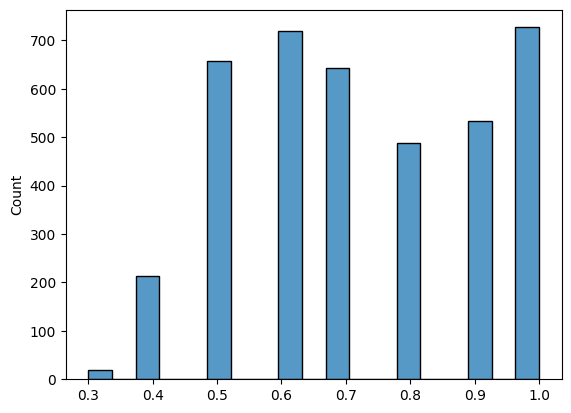

In [34]:
def create_subsets(gene_set, num_of_subsets=10):
    num_of_elem = len(gene_set)
    subsets = []
    for s in range(num_of_subsets):
        subset_size = random.randint(int(num_of_elem * 0.3), int(num_of_elem * 0.8))
        subsets.append(random.sample(gene_set, subset_size))
    return subsets
# *****************************************
# Precalculate inverse covariance matrices
# *****************************************
sc_dfs = {}
sc_icms = {}
sc_mean = {}
assigned_types = []
num_of_subsets = 10
subsets = create_subsets(markers_intersect, num_of_subsets=num_of_subsets)
for ty in cell_types:
    sc_dfs[ty] = []
    sc_icms[ty] = []
    sc_mean[ty] = []
    for sub_id, subset in enumerate(subsets):
        subset_df = sc_df[adata_sc.obs['cell_subclass'] == ty][subset]
        sc_dfs[ty].append(subset_df)
        cm = np.cov(subset_df.values, rowvar=False)  # Calculate covariance matrix
        sc_icms[ty].append(np.linalg.pinv(cm))  # Use pseudo inverse to avoid error singular matrix (determinant = 0) 
        sc_mean[ty].append(subset_df.mean())    # ...because of presence of genes with all zero values per cell type

# *****************************************
# For all ST cells, for all subsets, for all cell types
# *****************************************
for ii in range(len(st_df)):
    best_matches_subsets = []
    for sub_id, subset in enumerate(subsets):
        best_match = {'cell_type':'', 'dist':9999999}
        for ty in cell_types:
            maha = mahalanobis(st_df.iloc[ii, :][subset].values, sc_mean[ty][sub_id].values, sc_icms[ty][sub_id])
            # print(ty, maha)
            if maha < best_match['dist']:
                best_match = {'cell_type': ty, 'dist': maha}
        best_matches_subsets.append(best_match)
        # print('-----')
    # print(best_matches_subsets)
 
    # Majority voting
    cn = Counter([ x['cell_type'] for x in best_matches_subsets])
    best_match_subset = {'cell_type': cn.most_common(1)[0][0], 'confidence': np.round(cn.most_common(1)[0][1] / num_of_subsets, 3)}
    assigned_types.append(best_match_subset)
    if ii % 500 == 0:
        print(f'Processed {ii} out of {len(st_df)}.')
adata_st.obs['sc_type'] = [ x['cell_type'] for x in assigned_types]
sns.histplot([ x['confidence'] for x in assigned_types])
plt.savefig('ssi_confidence_hist.png', dpi=120, bbox_inches='tight')

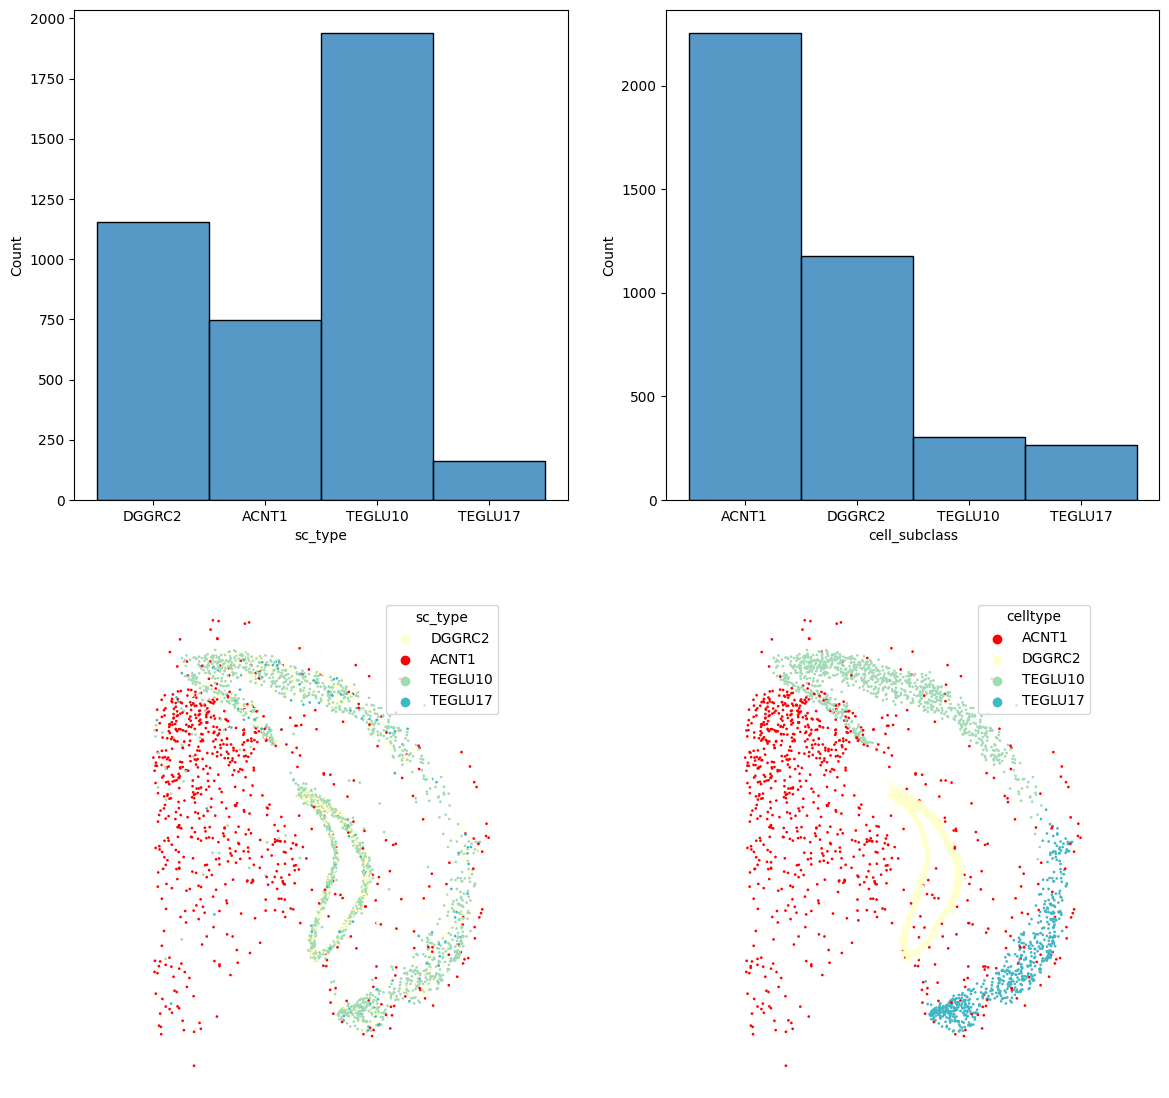

In [46]:
def plot_spatial(
        adata,
        annotation,
        ax: Axes,
        spot_size: float,
        palette=None,
        title: str = ""
):
    """
    Scatter plot in spatial coordinates.

    Parameters:
        - adata (AnnData): Annotated data object which represents the sample
        - annotation (str): adata.obs column used for grouping
        - ax (Axes): Axes object used for plotting
        - spot_size (int): Size of the dot that represents a cell. We are passing it as a diameter of the spot, while
                the plotting library uses radius therefore it is multiplied by 0.5
        - palette (dict): Dictionary that represents a mapping between annotation categories and colors
        - title (str): Title of the figure

    """
    s = spot_size * 0.5
    data = adata
    ax = sns.scatterplot(
        data=data.obs, hue=annotation, x=data.obsm['spatial'][:, 0], y=data.obsm['spatial'][:, 1],
        ax=ax, s=s, linewidth=0, palette=palette, marker='.'
    )
    ax.invert_yaxis()
    ax.set(yticklabels=[], xticklabels=[], title=title)
    ax.tick_params(bottom=False, left=False)
    ax.set_aspect("equal")
    sns.despine(bottom=True, left=True, ax=ax)
             
palette = {'DGGRC2': '#ffffcc', 'ACNT1':'r', 'TEGLU10':'#a1dab4', 'TEGLU17':'#41b6c4'}
fig, axs = plt.subplots(2, 2, figsize=(14, 14))
sns.histplot(adata_st.obs['sc_type'], ax=axs[0][0])
sns.histplot(adata_sc.obs['cell_subclass'], ax=axs[0][1])
plot_spatial(adata_st, annotation='sc_type', spot_size=30, palette=palette, ax=axs[1][0])
plot_spatial(adata_st, annotation='celltype', spot_size=30, palette=palette, ax=axs[1][1])
plt.savefig('ssi.png', dpi=120, bbox_inches='tight')

<Axes: xlabel='celltype', ylabel='Count'>

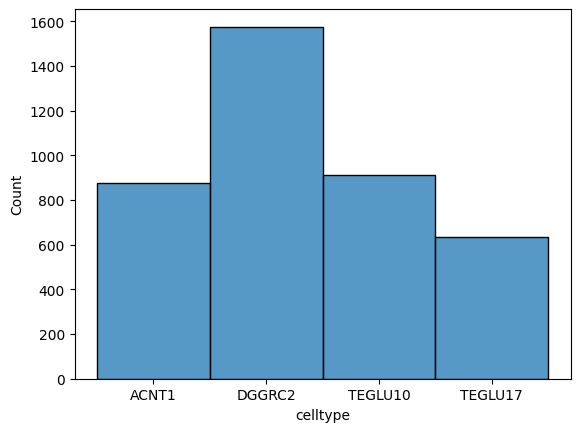

In [43]:
sns.histplot(adata_st.obs['celltype'])

In [210]:
a = [2, 2, 2]
dist = pd.DataFrame([[1, 2, 2], [1, 2, 2], [1,2,3], [2, 2, 3]])
cm = np.cov(dist, rowvar=False)  # Calculate covariance matrix
icm = np.linalg.pinv(cm)  # Use pseudo inverse to avoid error singular matrix (determinant = 0) 
mn = dist.mean()
maha = mahalanobis(a, mn.values, icm)
maha

2.5980762113533156

In [211]:
mn

0    1.25
1    2.00
2    2.50
dtype: float64

In [215]:
a = [2, 2, 2]
dist = pd.DataFrame([[1, 2, 2], [1, 2, 2], [1,2,3], [2, 2, 3], [1, 2, 2], [1, 2, 2], [1,2,3], [2, 2, 3]])
cm = np.cov(dist, rowvar=False)  # Calculate covariance matrix
icm = np.linalg.pinv(cm)  # Use pseudo inverse to avoid error singular matrix (determinant = 0) 
mn = dist.mean()
maha = mahalanobis(a, mn.values, icm)
maha

2.8062430400804557

In [213]:
mn

0    1.25
1    2.00
2    2.50
dtype: float64

In [209]:
a = [2, 2, 2]
dist = pd.DataFrame([[1, 2, 2], [1, 2, 2], [1,2,3], [2, 2, 1]])
cm = np.cov(dist, rowvar=False).T  # Calculate covariance matrix
icm = np.linalg.pinv(cm)  # Use pseudo inverse to avoid error singular matrix (determinant = 0) 
mn = dist.mean()
maha = mahalanobis(a, mn.values, icm)
maha

2.5980762113533165

In [206]:
a = [2, 2, 2]
dist = pd.DataFrame([[1, 2, 2], [1, 2, 2], [1,2,3], [2, 2, 2], [2, 2, 2], [2, 2, 2], [6,6,6], [6,6,6]])
cm = np.cov(dist, rowvar=False).T  # Calculate covariance matrix
icm = np.linalg.pinv(cm)  # Use pseudo inverse to avoid error singular matrix (determinant = 0) 
mn = dist.mean()
maha = mahalanobis(a, mn.values, icm)
maha

1.207614728849122